In [2]:
#import libraries for reading data and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

chr_19 = pd.read_csv("analytic_data2019.csv", low_memory=False)

#drop second row of variable names
chr_19 = chr_19.drop([0])

# drop all metrics (numerator, denominator, and confidence interval) except raw values 
for i, col in enumerate(chr_19.columns):
    if i < 7: pass
    elif col[-5:] != 'value':
        chr_19 = chr_19.drop(columns = col)

# drop and rename location columns
chr_19 = chr_19.drop(columns = ['State FIPS Code', 'County FIPS Code', 'County Ranked (Yes=1/No=0)'])
chr_19 = chr_19.rename(columns={"5-digit FIPS Code": "fips", "Name": "county", "Release Year": "year"})

# remove the text 'raw values' from column names to make more readable
for col in chr_19:
    if col[-5:] == 'value':
        chr_19 = chr_19.rename(columns={col: col[:-10]})

# only keep rows that include infant mortality 
chr_19 = chr_19[chr_19['Infant mortality'].isna() == False]

# print ratio of NA's in each column
#for col in chr_19.columns: print(col + ": " + str(chr_19[col].isna().sum() / len(chr_19[col])))
    
#drop variables with > 10% NaN
chr_19 = chr_19.loc[:, :'% Rural']
chr_19 = chr_19.drop(['Homicides', 
                      'Disconnected youth',
                      'Drinking water violations',
                      'Drug overdose deaths'], axis=1)

chr_19 = chr_19.drop(['fips', 'State Abbreviation', 'county', 'year'], axis=1)

chr_19 = chr_19.astype(float)

#drop redundant variables
chr_19 = chr_19.drop(['Uninsured adults', 
                     'Premature death', 
                     'Premature age-adjusted mortality', 
                     'Frequent mental distress', 
                     'Poor or fair health', 
                     'Frequent physical distress', 
                     'Food insecurity', 
                     'Poor mental health days', 
                     'Child mortality', 
                     'Children in poverty', 
                     '% not proficient in English', 
                     'Severe housing problems'], axis=1)

print("remaining counties: ", len(chr_19))
# drop 
chr_19 = chr_19.dropna()
print("final dataset dimensions: ", chr_19.shape)

#chr_19.to_csv('chr_2019_im.csv')

/Users/robgleich/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


remaining counties:  1312
final dataset dimensions:  (1142, 56)


In [3]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

y = chr_19['Infant mortality']
X = chr_19.drop(['Infant mortality'], axis=1)
# X = StandardScaler().fit_transform(X)


rfc = ensemble.RandomForestRegressor()
forest_scores = cross_val_score(rfc, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (forest_scores.mean(), forest_scores.std() * 2))


Accuracy: 0.57 (+/- 0.20)


In [6]:
#from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 29 (0.155751)
2. feature 1 (0.109721)
3. feature 22 (0.075388)
4. feature 47 (0.051563)
5. feature 30 (0.050607)
6. feature 2 (0.049114)
7. feature 23 (0.042136)
8. feature 37 (0.036617)
9. feature 5 (0.032487)
10. feature 10 (0.022080)
11. feature 3 (0.021078)
12. feature 38 (0.013937)
13. feature 53 (0.013385)
14. feature 51 (0.013217)
15. feature 54 (0.012177)
16. feature 6 (0.011007)
17. feature 7 (0.010953)
18. feature 43 (0.010725)
19. feature 33 (0.010503)
20. feature 4 (0.010229)
21. feature 25 (0.008930)
22. feature 44 (0.008742)
23. feature 52 (0.008706)
24. feature 41 (0.008700)
25. feature 46 (0.008668)
26. feature 0 (0.008496)
27. feature 9 (0.008168)
28. feature 8 (0.008156)
29. feature 32 (0.008080)
30. feature 19 (0.008008)
31. feature 17 (0.007863)
32. feature 21 (0.007832)
33. feature 39 (0.007680)
34. feature 13 (0.007244)
35. feature 16 (0.007014)
36. feature 20 (0.006978)
37. feature 15 (0.006920)
38. feature 45 (0.006899)
39. feature 40

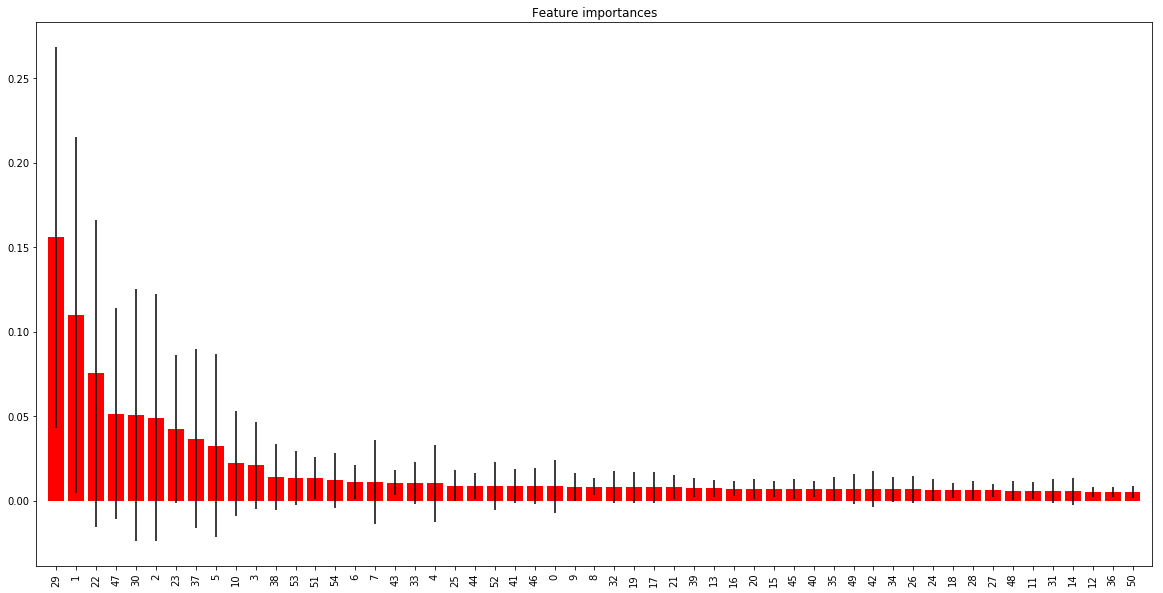

In [7]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()